In [1]:
from openbb_terminal.sdk import openbb
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf

import statsmodels.api as sm

from pykalman import KalmanFilter

from sklearn.decomposition import PCA
from statsmodels import regression
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

def omega_ratio(returns, required_return=0.0):
    """Determines the Omega ratio of a strategy.

    Parameters
    ----------
    returns: pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    required_return: float, optional
        Minimum acceptance return of the investor. Threshold over which to
        consider positive vs negative returns. It will be converted to a 
        value appropritae for the period of the returns. E.g An annual minimum
        acceptable return of 100 will translate to a minimum acceptable
        reutnr of 0.018

    Returns
    -------
    omega_ratio : float

    Note
    ----
    See https://en.wikipedia.org/wiki/Omega_ratio for more details.
    """

    return_threshold = (1 + required_return) ** (1/252) - 1

    returns_less_thresh = returns - return_threshold

    numer = sum(returns_less_thresh[returns_less_thresh > 0.0])
    denom = -1.0 * sum(returns_less_thresh[returns_less_thresh < 0.0])

    if denom > 0.0:
        return numer / denom
    
    return np.nan

In [3]:
# data = yf.download("aapl", start="2020-01-01", end="2021-12-31")


data = openbb.stocks.load("aapl", start_date="2020-01-01", end_date="2023-01-01")
returns = data["Adj Close"].pct_change()

Loading Daily data for AAPL with starting period 2020-01-02.

<AxesSubplot: >

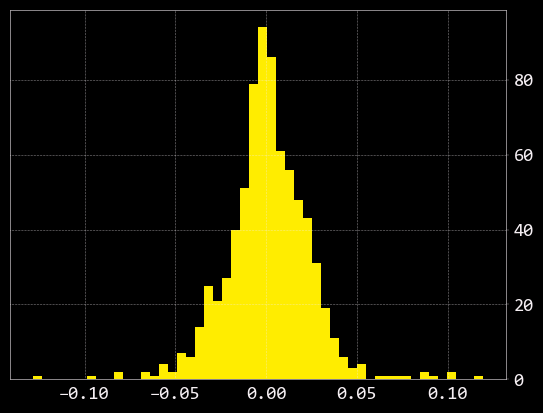

In [4]:
returns.hist(bins=50)

In [5]:
returns.skew()

0.09503923159587269

In [6]:
returns.kurtosis()

4.04011857620209

In [7]:
# We use a threshold of 7% which is the historical average annual return of the stock market
omega_ratio(returns, 0.07)

1.0949649256880054

In [8]:
# Taking into consideration skew and kurtosis AAPL gains outperformed the losses by a factor of 1.2
# See also Tail risk (not taken into account with sharpe ratio)

In [9]:
# df = openbb.economy.unemp(2010)

df = data[:"2020-12-31"].sort_index()
#returns_nadropped = df.loc[:"Adj Close"].pct_change().dropna()

In [10]:
returns_nadropped_still_df = df.loc[:,("Adj Close",)].pct_change().dropna()
returns_nadropped_still_df

,Adj Close
date,
2020-01-03,-0.009722
2020-01-06,0.007968
2020-01-07,-0.004703
2020-01-08,0.016086
2020-01-09,0.021241
...,...
2020-12-24,0.007712
2020-12-28,0.035766
2020-12-29,-0.013315


In [11]:
returns_nadropped_still_df = returns_nadropped_still_df.asfreq('D')
returns_nadropped_still_df

,Adj Close
date,
2020-01-03,-0.009722
2020-01-04,NaN
2020-01-05,NaN
2020-01-06,0.007968
2020-01-07,-0.004703
...,...
2020-12-27,NaN
2020-12-28,0.035766
2020-12-29,-0.013315


In [12]:
returns_nadropped_still_df = returns_nadropped_still_df.fillna(method="ffill")
returns_nadropped_still_df

,Adj Close
date,
2020-01-03,-0.009722
2020-01-04,-0.009722
2020-01-05,-0.009722
2020-01-06,0.007968
2020-01-07,-0.004703
...,...
2020-12-27,0.007712
2020-12-28,0.035766
2020-12-29,-0.013315


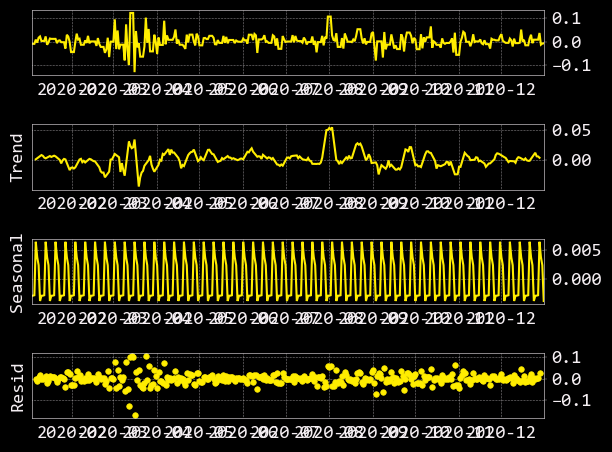

In [13]:
decomposition_results = seasonal_decompose(returns_nadropped_still_df, model="additive").plot()

Text(0.5, 0.98, 'STL Decomposition')

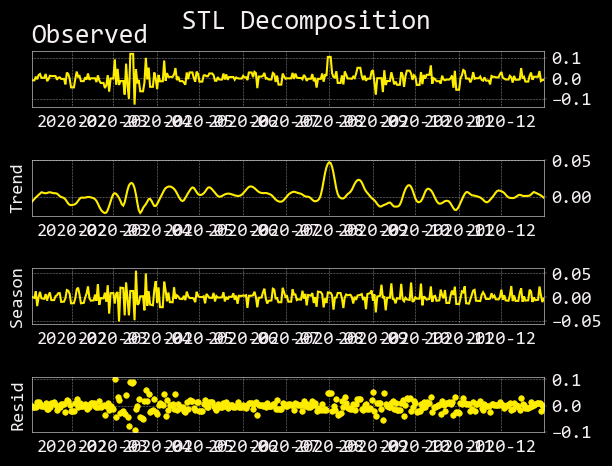

In [14]:
stl_decomposition = STL(returns_nadropped_still_df).fit()
stl_decomposition.plot().suptitle("STL Decomposition")

In [16]:
data = openbb.stocks.load("aapl", start_date="2010-01-01", end_date="2023-01-01")
df = data["Adj Close"]

for lag in [20,100,250,500,1000]:
    hurst_exp = get_hurst_exponent(data.values, lag)
    print(f"{lag} lags: {hurst_exp:.4f}")

Loading Daily data for AAPL with starting period 2010-01-04.

20 lags: 0.0754
100 lags: 0.0673
250 lags: 0.0407
500 lags: 0.0474
1000 lags: 0.0998


In [17]:
shorter_series = df.loc["2015":"2023"].values
for lag in [20,100,250,500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"{lag} lags: {hurst_exp:.4f}")   

20 lags: 0.4793
100 lags: 0.4327
250 lags: 0.4326
500 lags: 0.4696


Loading Daily data for AAPL with starting period 2021-01-04.

Text(0, 0.5, 'Price')

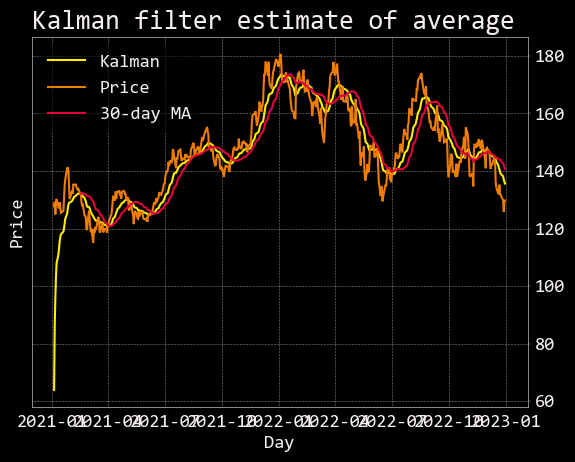

In [18]:
data = openbb.stocks.load("AAPL", start_date="2021-01-01", end_date="2023-01-01")
prices = data["Adj Close"]

kf = KalmanFilter(
    transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance = 1,
    transition_covariance=0.01
)

state_means, _ = kf.filter(prices.values)
state_means = pd.Series(state_means.flatten(), index=prices.index)

mean30 = prices.rolling(window=30).mean()

plt.plot(state_means)
plt.plot(prices)
plt.plot(mean30)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman', 'Price', '30-day MA'])
plt.xlabel('Day')
plt.ylabel('Price')


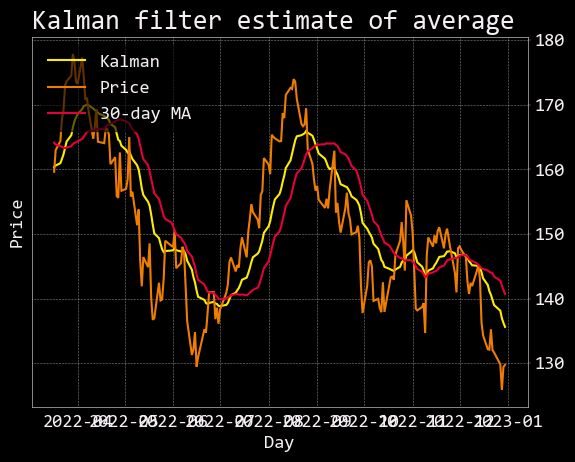

In [19]:
# Zoom in on the last 200 days to get a closer look.

plt.plot(state_means[-200:])
plt.plot(prices[-200:])
plt.plot(mean30[-200:])
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman', 'Price', '30-day MA'])
plt.xlabel('Day')
plt.ylabel('Price');